In [48]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline
import healpy

from astropy.time import Time

import lsst.sims.maf.plots as plots
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as mb

from lsst.sims.utils import Site, ObservationMetaData
from lsst.sims.utils import calcLmstLast, _altAzPaFromRaDec

# For TS observatory model
from lsst.ts.observatory.model import Target
from lsst.ts.observatory.model import ObservatoryModel
from lsst.ts.observatory.model import ObservatoryState
from lsst.ts.observatory.model import ObservatoryPosition
from lsst.ts.dateloc import DateProfile, ObservatoryLocation

In [67]:
lsstSite = Site('LSST')
observatoryLocation = ObservatoryLocation()
observatoryLocation.for_lsst()

tnow = 59580.0
t = Time(tnow, format='mjd', scale='utc')

dateProfile = DateProfile(t.unix, observatoryLocation)
print(dateProfile.mjd)


observatoryModel = ObservatoryModel(location=observatoryLocation)
observatoryModel.configure_from_module()
observatoryModel.update_state(t.unix)
observatoryModel.params.follow_sky = False

59580.0


In [83]:
# Set up a bunch of points to point at across the sky.
s = slicers.HealpixSlicer(nside=32)
ra = s.slicePoints['ra']
dec = s.slicePoints['dec']
alt = np.zeros(len(ra), float)
az = np.zeros(len(ra), float)
for i in range(len(alt)):
    alt[i], az[i], pa = observatoryModel.radec2altazpa(dateProfile, ra[i], dec[i])
#obs = ObservationMetaData(mjd=tnow)
#alt, az, pa = _altAzPaFromRaDec(ra, dec, obs, includeRefraction=False)
#alt, az = stackers.raDec2AltAz(ra, dec, lsstSite.latitude_rad, lsstSite.longitude_rad, tnow)
lmst, last = calcLmstLast(tnow, lsstSite.longitude_rad)
lmst_deg = lmst / 24.0 * 360.0
lst = np.degrees(dateProfile.lst_rad)
print('LMST', lmst, 'hrs', lmst_deg, 'deg', lst, '(date profile lst)')
azmask = np.where(alt<0, True, False)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
LMST 1.99204240346 hrs 29.8806360519 deg 29.8806360519 (date profile lst)


In [69]:
# Convert their ra/decs to alt/az
telRA = np.radians(lmst_deg)
telDec = np.radians(10)
telAlt, telAz, telPA = observatoryModel.radec2altazpa(dateProfile, telRA, telDec)
#telAlt, telAz, telPA = _altAzPaFromRaDec(ra, dec, obs, includeRefraction=False)
#telAlt, telAz = stackers.raDec2AltAz(np.array([telRA]), np.array([telDec]),
#                                     lsstSite.latitude_rad, lsstSite.longitude_rad, tnow)
#telAlt = telAlt[0]
#telAz = telAz[0]
print('Tel ra/dec', np.degrees(telRA), np.degrees(telDec), 'alt/az', np.degrees(telAlt), np.degrees(telAz))

Tel ra/dec 29.8806360519 10.0 alt/az 49.7556 2.90897415184e-14


1

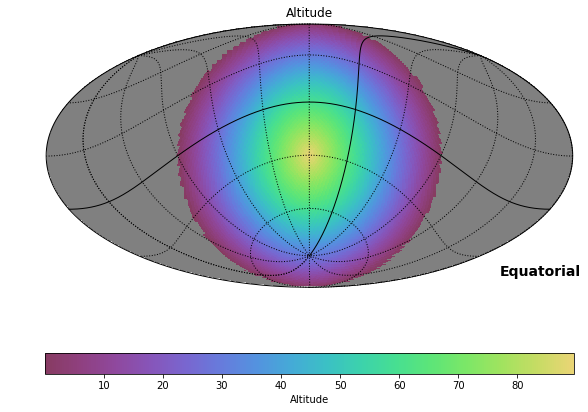

In [70]:
# Plot their alt/az location
val = ma.MaskedArray(data=np.degrees(alt), mask=azmask)
rot = (lmst_deg, lsstSite.latitude, 0)
plotDict = {'figsize':(10, 6), 'title': 'Altitude', 'xlabel': 'Altitude', 'rot':rot}
plots.HealpixSkyMap()(val, s, plotDict)

In [71]:
# First get observatory model set up correctly. 
# tnow is in MJD (TAI) and we need to convert to unix timestamp.

t = Time(tnow, format='mjd', scale='tai')

observatoryModel = ObservatoryModel()
observatoryModel.configure_from_module()
observatoryModel.update_state(t.unix)
observatoryModel.params.follow_sky = False

In [72]:
# Set new observatory position/state.
startTarget = Target(band_filter='g', ra_rad=telRA, dec_rad=telDec, num_exp=1, exp_times=[15.0, 15.0])
observatoryModel.slew(startTarget)
observatoryModel.update_state(t.unix)
print(observatoryModel.current_state)

t=1640995303.0 ra=29.881 dec=10.000 ang=180.207 filter=g track=True alt=49.753 az=359.344 pa=179.425 rot=359.218 telaz=-0.656 telrot=-0.782 mounted=['g', 'r', 'i', 'z', 'y'] unmounted=['u']


In [73]:
#%%timeit 925 µs ± 34.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# Calculate slew times using quick slew calculation
slewtime = observatoryModel.get_approximateSlewTime(alt, az, 'g')

1

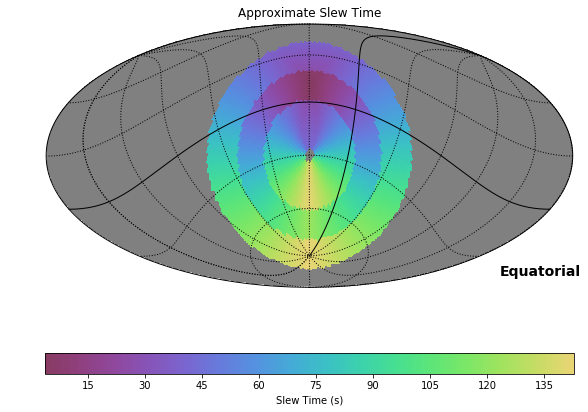

In [74]:
slewmask = np.where(slewtime < 0, True, False)
val = ma.MaskedArray(data=slewtime, mask=slewmask, fillvalue=healpy.UNSEEN)
plotDict = {'figsize':(10, 6), 'title': 'Approximate Slew Time', 'xlabel': 'Slew Time (s)', 'rot':rot}
plots.HealpixSkyMap()(val, s, plotDict)

In [75]:
#%%timeit #264 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
slewT = np.zeros(len(ra), float)
for i in range(len(slewT)):
    target = Target(band_filter='g', ra_rad=ra[i], dec_rad=dec[i], num_exp=2, exp_times=[15.0, 15.0])
    slewT[i] = observatoryModel.get_slew_delay(target)
#slewT.min(), slewT.max()

1

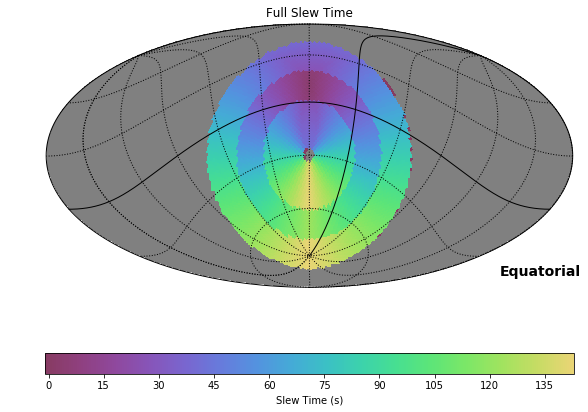

In [78]:
val = ma.MaskedArray(data=slewT, mask=slewmask)
plotDict = {'figsize':(10, 6), 'title': 'Full Slew Time', 'xlabel': 'Slew Time (s)', 'rot':rot}
plots.HealpixSkyMap()(val, s, plotDict)

Min and max differences in (approximate - full ts_observatory_model.get_slew_delay) -113.121359429 0.0


1

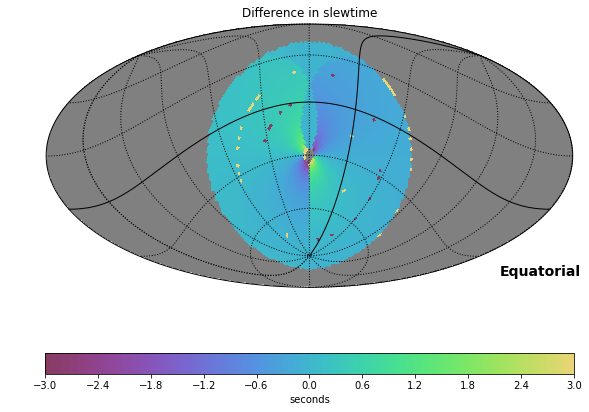

In [79]:
diff = slewtime - slewT
print('Min and max differences in (approximate - full ts_observatory_model.get_slew_delay)',
      diff[slewmask].min(), diff[slewmask].max())
val = ma.MaskedArray(data=diff, mask=slewmask)
plotDict = {'figsize':(10, 6), 'title': 'Difference in slewtime', 
            'xlabel': 'seconds', 'rot':rot,
            'colorMin':-3, 'colorMax':3}
plots.HealpixSkyMap()(val, s, plotDict)

The offsets do not seem to be due to differences in applying the closed loop optics corrections, but rather due to small differences in alt/az and ra/dec in each calculation (although I have here made sure to use the opsim alt/az calculation  so ..?).  At the end of the day though, the approximateSlewTime is intended to be approximate and this seems close enough.